In [12]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np


# disaster_data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
#                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
#                            2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
#                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
#                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
#                            3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
#                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

disaster_data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, 4, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)
disaster_data = disaster_data.to_frame()
disaster_data['year'] = years

In [47]:
import arviz as az

m_kwars = dict(early_rate_lambda=1, late_rate_lambda=1)

with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform('switchpoint', lower=disaster_data['year'].min(), upper = disaster_data['year'].max(), testval=disaster_data['year'].median())

    early_rate = pm.Exponential('early_rate', m_kwars['early_rate_lambda'])
    late_rate = pm.Exponential('late_rate', m_kwars['late_rate_lambda'])

    rate = pm.math.switch(switchpoint >= disaster_data['year'], early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data[0])
    trace = pm.sample()
    prior = pm.sample_prior_predictive()
    posterior = pm.sample_posterior_predictive(trace)
    waic = pm.waic(trace)




Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [48]:
import arviz as az

m_kwars = dict(early_rate_lambda=5, late_rate_lambda=.5)

with pm.Model() as disaster_model2:
    switchpoint = pm.DiscreteUniform('switchpoint', lower=disaster_data['year'].min(), upper = disaster_data['year'].max(), testval=disaster_data['year'].median())

    early_rate = pm.Exponential('early_rate', m_kwars['early_rate_lambda'])
    late_rate = pm.Exponential('late_rate', m_kwars['late_rate_lambda'])

    rate = pm.math.switch(switchpoint >= disaster_data['year'], early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data[0])
    trace = pm.sample()
    prior = pm.sample_prior_predictive()
    posterior = pm.sample_posterior_predictive(trace)
    waic = pm.waic(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [24]:
with disaster_model:
    pm_data = az.from_pymc3(
        prior=prior,
        posterior_predictive=posterior,
        trace=trace,
    )

In [49]:
with disaster_model:
    pm_data2 = az.from_pymc3(
        prior=prior,
        posterior_predictive=posterior,
        trace=trace,
    )

In [58]:
co = az.compare({'prior1':pm_data, 'prior2':pm_data2}, ic='waic', scale='log')

In [75]:
kwg = dict(height=450, width=650,toolbar_location='right')
plot = az.plot_compare(
        co,
        backend='bokeh',
        show=False,
        backend_kwargs=kwg,
        )

TypeError: plot_compare() got an unexpected keyword argument 'legend'

In [74]:
import panel as pn
pn.serve(plot)

Launching server at http://localhost:51136


In [21]:
waic

Computed from 4000 by 111 log-likelihood matrix

          Estimate       SE
elpd_waic  -174.63     8.05
p_waic        3.06        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

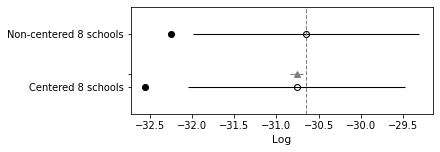

In [42]:
>>> import arviz as az
>>> model_compare = az.compare({'Centered 8 schools': az.load_arviz_data('centered_eight'),
>>>                  'Non-centered 8 schools': az.load_arviz_data('non_centered_eight')}, ic='waic')
>>> az.plot_compare(model_compare)

In [43]:
model_compare

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Non-centered 8 schools,0,-30.646,0.800621,0,0.527978,1.34109,0,False,log
Centered 8 schools,1,-30.758,0.901656,0.111954,0.472022,1.28429,0.0777372,False,log


In [44]:
co.waic = -30.6

In [65]:
%load_ext autoreload
%autoreload 2
from prior_comparison_tool.plots import compare_plot

plot = compare_plot(data={'prior1': m, 'prior2':m})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
d = az.compare({'prior2':m.model_arviz_data})

AttributeError: 'NoneType' object has no attribute 'model_arviz_data'

In [91]:
dat = pd.DataFrame(columns=['rank','waic' ,  'p_waic', 'd_waic', 'weight','se','dse', 'warning','waic_scale'])

In [103]:
import arviz as az
model_compare = az.compare({'Centered 8 schools': az.load_arviz_data('centered_eight'),
                 'Non-centered 8 schools': az.load_arviz_data('non_centered_eight')}, ic='waic')
az.plot_compare(model_compare, backend='bokeh')

Figure(id='2345', ...)

In [114]:
model_compare

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Non-centered 8 schools,0,-1221.4,1.83989,0,1,11.7578,0,False,log
Centered 8 schools,1,-30.758,0.901656,0.111954,0.471499,1.27624,0.0777372,False,log


In [113]:
model_compare.xs('Non-centered 8 schools')['waic']=-1221.4
model_compare.xs('Non-centered 8 schools')['se']=11.7578
model_compare.xs('Non-centered 8 schools')['weight']=1
model_compare.xs('Non-centered 8 schools')['p_waic']=1.83989

In [115]:
pn.serve(az.plot_compare(model_compare, backend='bokeh'))

Launching server at http://localhost:62154


In [56]:
plot.size

0

In [14]:
import panel as pn
pn.serve(plot)

Launching server at http://localhost:53745


In [8]:
with disaster_model:
    # dims = {
    #     'disasters':['year'],
    #     # 'early_rate':['disasters'],
    #     # 'late_rate':['disasters'],
    # }
    pm_data = az.from_pymc3(
            trace=trace,
            posterior_predictive=posterior,
            # prior=prior,
            # coords={
            #     'years':disaster_data['year'],
            # },
            # dims=dims,
        )

In [9]:
pm_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [34]:
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [56]:
list(disaster_data['year'].values)

[1851,
 1852,
 1853,
 1854,
 1855,
 1856,
 1857,
 1858,
 1859,
 1860,
 1861,
 1862,
 1863,
 1864,
 1865,
 1866,
 1867,
 1868,
 1869,
 1870,
 1871,
 1872,
 1873,
 1874,
 1875,
 1876,
 1877,
 1878,
 1879,
 1880,
 1881,
 1882,
 1883,
 1884,
 1885,
 1886,
 1887,
 1888,
 1889,
 1890,
 1891,
 1892,
 1893,
 1894,
 1895,
 1896,
 1897,
 1898,
 1899,
 1900,
 1901,
 1902,
 1903,
 1904,
 1905,
 1906,
 1907,
 1908,
 1909,
 1910,
 1911,
 1912,
 1913,
 1914,
 1915,
 1916,
 1917,
 1918,
 1919,
 1920,
 1921,
 1922,
 1923,
 1924,
 1925,
 1926,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1939,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961]